In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV



#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [3]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [4]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'elevation:m', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms', 'absolute_humidity_2m:gm3'], axis=1)
    return df


In [5]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [6]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [7]:
def feature_date(df):
    df["month"] = [df["date"][i].month for i in range(len(df))]
    df["hour"] = [df["date"][i].hour for i in range(len(df))]
    df.pop('date')


In [8]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [9]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [10]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [11]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [12]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [13]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [14]:
# Remove columns which are not needed
#train_data_a = remove_unused_columns(train_data_a)
#val_data_a = remove_unused_columns(val_data_a)
#test_a = remove_unused_columns(test_a)

#train_data_b = remove_unused_columns(train_data_b)
#val_data_b = remove_unused_columns(val_data_b)
#test_b = remove_unused_columns(test_b)

#train_data_c = remove_unused_columns(train_data_c)
#val_data_c = remove_unused_columns(val_data_c)
#test_c = remove_unused_columns(test_c)

In [15]:
#Convert date into sin and cos components
#convert_date_to_sin_and_cos(train_data_a)
#convert_date_to_sin_and_cos(val_data_a)
#convert_date_to_sin_and_cos(test_a)

#convert_date_to_sin_and_cos(train_data_b)
#convert_date_to_sin_and_cos(val_data_b)
#convert_date_to_sin_and_cos(test_b)

#convert_date_to_sin_and_cos(train_data_c)
#convert_date_to_sin_and_cos(val_data_c)
#convert_date_to_sin_and_cos(test_c)


#Extract date components
feature_date(train_data_a)
feature_date(val_data_a)
feature_date(test_a)

feature_date(train_data_b)
feature_date(val_data_b)
feature_date(test_b)

feature_date(train_data_c)
feature_date(val_data_c)
feature_date(test_c)

In [16]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [17]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [18]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [19]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

In [20]:
train_data_c = train_data_c[5800:]
train_data_b = train_data_b.drop(train_data_b.index[13410:14460])
train_data_b = train_data_b.reset_index()
train_data_c = train_data_c.reset_index()
train_data_b = train_data_b.drop(['index'], axis=1)
train_data_c = train_data_c.drop(['index'], axis=1)

In [21]:
train_data_b.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,pv_measurement,month,hour
0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,0.0,275.149994,0.0,0.0,0.0,0.0,81.824997,0,1,987.000000,0.0375,0.75,974.099976,980.174988,0.0,89.099998,986.224976,0.05,20.724251,-48.319252,0.000,278.250000,86.324997,16827.800781,2.800,1.175,2.550,0.0,1,0
1,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,0.0,274.825012,0.0,0.0,0.0,0.0,97.474998,0,1,986.150024,0.0125,0.25,973.250000,979.325012,0.0,88.425003,985.400024,0.10,40.307251,-44.919750,0.000,278.075012,99.074997,12777.449219,3.550,1.525,3.200,0.0,1,1
2,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,0.0,274.799988,0.0,0.0,0.0,0.0,96.425003,0,1,985.950012,0.0000,0.00,973.049988,979.099976,0.0,87.300003,985.174988,0.10,57.805000,-39.863998,0.100,278.049988,97.925003,11140.500000,4.025,2.150,3.425,0.0,1,2
3,5.350,1.23975,1021.150024,0.0,0.0,1021.150024,0.0,274.674988,0.0,0.0,0.0,0.0,96.775002,0,1,986.250000,0.0450,0.75,973.349976,979.349976,0.0,88.400002,985.450012,0.10,73.371002,-33.769001,0.200,277.600006,97.224998,6799.200195,4.900,3.425,3.500,0.0,1,3
4,5.675,1.23750,1033.699951,0.0,0.0,1033.699951,0.0,275.500000,0.0,0.0,0.0,0.0,96.724998,0,1,986.775024,0.0150,0.25,973.875000,979.900024,0.0,91.275002,985.974976,0.10,87.514999,-27.167500,0.175,277.649994,96.824997,5580.475098,6.050,5.575,2.200,0.0,1,4


In [22]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [23]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [24]:
import gc
gc.collect()

0

[0]	train-mae:543.02872+3.06644	test-mae:542.94640+13.17258
[1]	train-mae:442.32008+2.37536	test-mae:444.27905+10.01050
[2]	train-mae:368.07470+1.89515	test-mae:372.91782+7.32990
[3]	train-mae:314.53645+1.59157	test-mae:322.44400+5.87278
[4]	train-mae:275.69563+1.06792	test-mae:287.03136+4.66592
[5]	train-mae:247.82385+0.77462	test-mae:262.16086+4.18567
[6]	train-mae:227.78784+0.72612	test-mae:245.19837+3.42084
[7]	train-mae:212.62985+0.70547	test-mae:232.81059+3.10635
[8]	train-mae:201.19083+1.21926	test-mae:223.93836+2.84544
[9]	train-mae:192.31398+1.05349	test-mae:217.55944+2.62012
[10]	train-mae:185.29777+1.04342	test-mae:212.98454+2.37173
[11]	train-mae:179.74475+1.33815	test-mae:209.61717+2.34816
[12]	train-mae:175.29032+1.39726	test-mae:207.17485+2.41575
[13]	train-mae:171.55835+1.20465	test-mae:205.31328+2.27100
[14]	train-mae:168.50170+1.35101	test-mae:203.87423+2.17584
[15]	train-mae:165.81957+1.09707	test-mae:202.77102+1.95030
[16]	train-mae:163.67682+1.11959	test-mae:201.97

[38]	validation_0-mae:147.67753	validation_1-mae:122.24566
[39]	validation_0-mae:147.00384	validation_1-mae:122.22510
[40]	validation_0-mae:146.12085	validation_1-mae:122.13522
[41]	validation_0-mae:145.07482	validation_1-mae:122.47571
[42]	validation_0-mae:144.01981	validation_1-mae:122.42263
[43]	validation_0-mae:143.39333	validation_1-mae:122.42043
[44]	validation_0-mae:142.66365	validation_1-mae:122.63100
[45]	validation_0-mae:142.00054	validation_1-mae:122.65794
[46]	validation_0-mae:141.42984	validation_1-mae:122.73702
[47]	validation_0-mae:140.50445	validation_1-mae:122.93846
[48]	validation_0-mae:139.91545	validation_1-mae:123.05665
[49]	validation_0-mae:139.21474	validation_1-mae:123.14792
[50]	validation_0-mae:138.43627	validation_1-mae:123.75962
[51]	validation_0-mae:137.40698	validation_1-mae:123.08561
[52]	validation_0-mae:137.05818	validation_1-mae:122.77419
[53]	validation_0-mae:136.57453	validation_1-mae:122.78668
[54]	validation_0-mae:136.06882	validation_1-mae:122.663

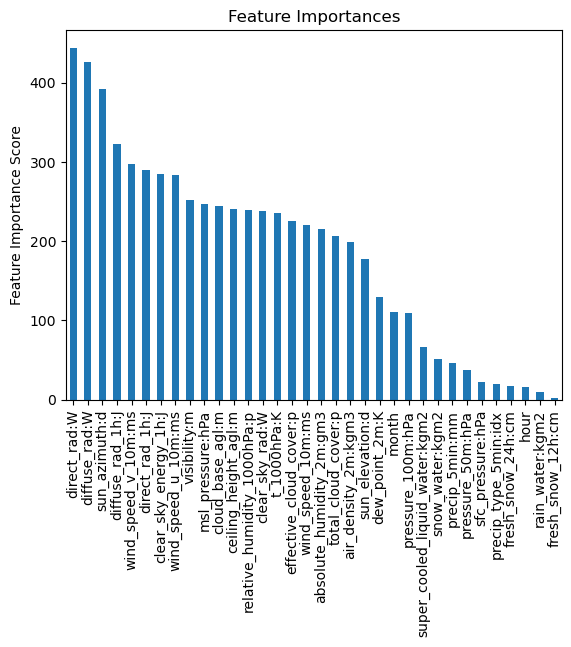

In [25]:
model_a = xgb.XGBRegressor(
 #device='cuda',
 learning_rate =0.2,
 n_estimators=100,
 max_depth=7,
 min_child_weight=6,
 gamma=0.0,
 subsample=0.75,
 colsample_bytree=0.85,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha=99
)
#base: 111.09641204863941 124.56255801196808
#131.1067651482959 119.79052672079942 eta:0.01 n=1000


modelfit(model_a, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV = False)

[0]	train-mae:83.71273+0.39104	test-mae:83.68694+2.15642
[1]	train-mae:72.35982+0.41399	test-mae:72.49247+1.77923
[2]	train-mae:63.98581+0.41175	test-mae:64.23066+1.61268
[3]	train-mae:57.82712+0.32941	test-mae:58.10964+1.47180
[4]	train-mae:53.30277+0.32354	test-mae:53.65837+1.27970
[5]	train-mae:50.11587+0.24412	test-mae:50.55718+1.04753
[6]	train-mae:47.86839+0.20178	test-mae:48.41296+0.92250
[7]	train-mae:46.06783+0.31010	test-mae:46.68186+0.68642
[8]	train-mae:44.69184+0.34801	test-mae:45.39818+0.65319
[9]	train-mae:43.68853+0.33195	test-mae:44.45558+0.66075
[10]	train-mae:42.79861+0.31124	test-mae:43.58460+0.68551
[11]	train-mae:42.13938+0.22306	test-mae:42.95318+0.76966
[12]	train-mae:41.65612+0.17629	test-mae:42.47414+0.77479
[13]	train-mae:41.18574+0.19551	test-mae:42.08019+0.72452
[14]	train-mae:40.85423+0.22108	test-mae:41.79323+0.72181
[15]	train-mae:40.53574+0.21923	test-mae:41.52430+0.72265
[16]	train-mae:40.26425+0.18624	test-mae:41.32693+0.78517
[17]	train-mae:40.00552+

[141]	train-mae:34.06943+0.30669	test-mae:38.86483+0.64679
[0]	validation_0-mae:83.46533	validation_1-mae:43.22252
[1]	validation_0-mae:71.96906	validation_1-mae:38.12400
[2]	validation_0-mae:63.82565	validation_1-mae:34.67762
[3]	validation_0-mae:57.71064	validation_1-mae:31.82929
[4]	validation_0-mae:53.35808	validation_1-mae:30.29074
[5]	validation_0-mae:50.06477	validation_1-mae:28.95498
[6]	validation_0-mae:47.98276	validation_1-mae:28.27378
[7]	validation_0-mae:46.12551	validation_1-mae:27.31500
[8]	validation_0-mae:44.73106	validation_1-mae:26.66425
[9]	validation_0-mae:43.83466	validation_1-mae:25.88992
[10]	validation_0-mae:43.02622	validation_1-mae:25.40819
[11]	validation_0-mae:42.55996	validation_1-mae:24.88369
[12]	validation_0-mae:41.89334	validation_1-mae:24.68198
[13]	validation_0-mae:41.47704	validation_1-mae:24.23000
[14]	validation_0-mae:40.95490	validation_1-mae:24.18139
[15]	validation_0-mae:40.59971	validation_1-mae:24.05863
[16]	validation_0-mae:40.31798	validati

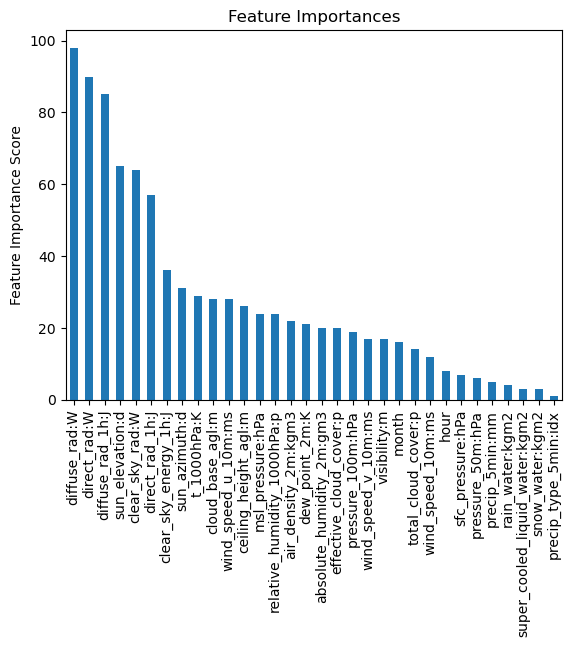

In [41]:
model_b = xgb.XGBRegressor(
 #device='cuda',
 learning_rate =0.2,
 n_estimators=500,
 max_depth=3,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.6,
 colsample_bytree=0.75,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha= 0.05,
)

#base 19.711947528979213 25.370240626068227 n = 279
#32.690610316877326 24.550833701848756 n= 205
#34.626780351457285 23.886838565572145 n = 131




modelfit(model_b, train_data_b, train_b_y, val_data_b, val_b_y, useTrainCV = True)

[0]	validation_0-mae:66.65336	validation_1-mae:33.15343
[1]	validation_0-mae:55.32927	validation_1-mae:27.95362
[2]	validation_0-mae:46.70970	validation_1-mae:23.89395
[3]	validation_0-mae:40.16263	validation_1-mae:21.61697
[4]	validation_0-mae:35.34024	validation_1-mae:20.43348
[5]	validation_0-mae:31.86097	validation_1-mae:20.00979
[6]	validation_0-mae:29.18713	validation_1-mae:19.41446
[7]	validation_0-mae:27.15406	validation_1-mae:19.48942
[8]	validation_0-mae:25.68765	validation_1-mae:19.48556
[9]	validation_0-mae:24.60224	validation_1-mae:19.79135
[10]	validation_0-mae:23.70404	validation_1-mae:19.98811
[11]	validation_0-mae:23.06350	validation_1-mae:20.02923
[12]	validation_0-mae:22.58999	validation_1-mae:19.91449
[13]	validation_0-mae:22.20487	validation_1-mae:20.06611
[14]	validation_0-mae:21.90472	validation_1-mae:20.18858
[15]	validation_0-mae:21.67770	validation_1-mae:20.42640
[16]	validation_0-mae:21.50239	validation_1-mae:20.49316
[17]	validation_0-mae:21.31323	validation

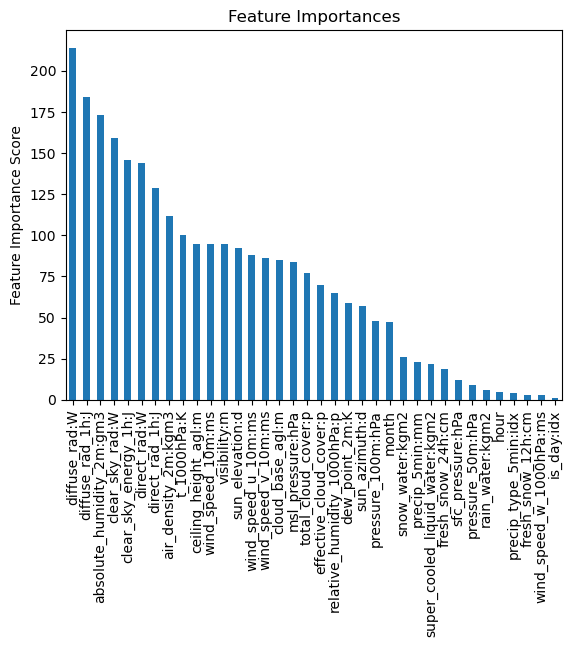

In [27]:
model_c = xgb.XGBRegressor(
 #device='cuda',
 learning_rate =0.2,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
)



modelfit(model_c, train_data_c, train_c_y, val_data_c, val_c_y, useTrainCV = False)

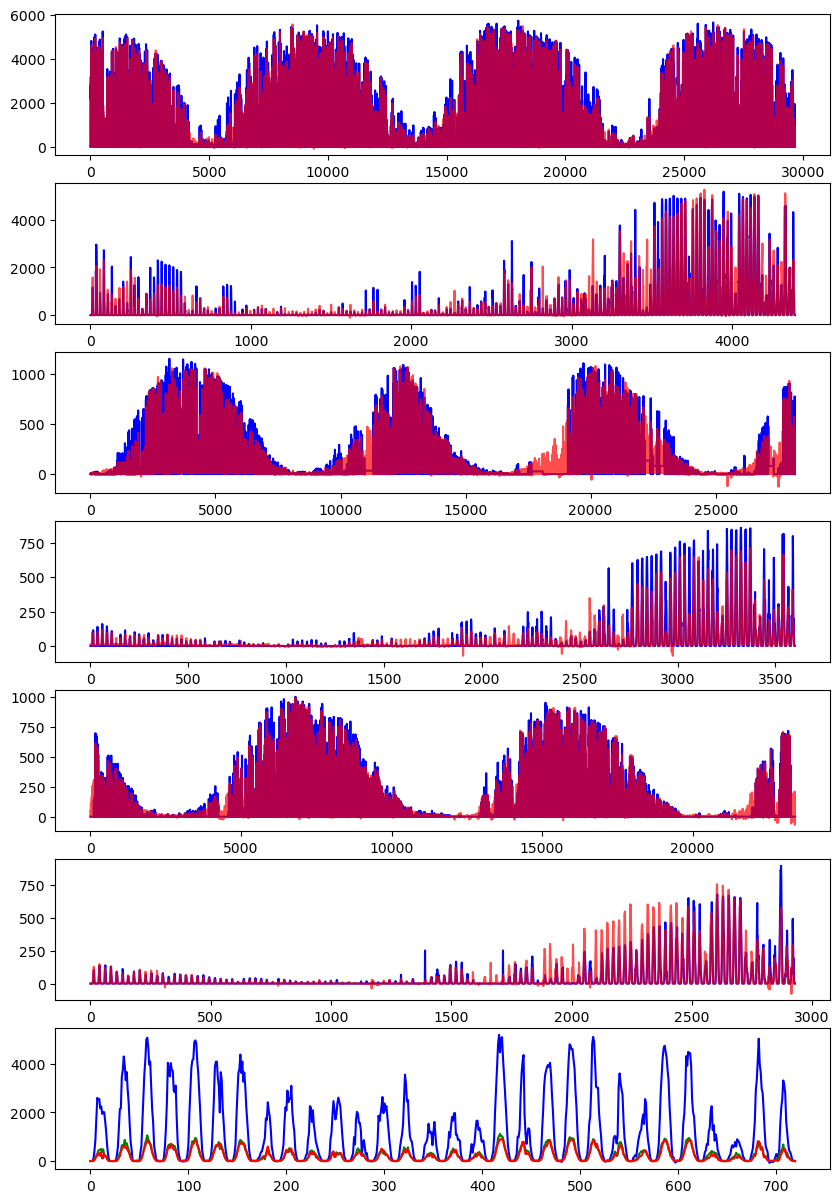

In [46]:
preds_a_train = model_a.predict(train_data_a)
preds_a_val = model_a.predict(val_data_a)
preds_a_test = model_a.predict(test_a)

preds_b_train = model_b.predict(train_data_b)
preds_b_val = model_b.predict(val_data_b)
preds_b_test = model_b.predict(test_b)

preds_c_train = model_c.predict(train_data_c)
preds_c_val = model_c.predict(val_data_c)
preds_c_test = model_c.predict(test_c)

fig, axs = plt.subplots(7, figsize=(10, 15))
axs[0].plot(train_a_y, color="blue")
axs[0].plot(preds_a_train, color="red", alpha=0.7)

axs[1].plot(val_a_y, color="blue")
axs[1].plot(preds_a_val, color="red", alpha=0.7)


axs[2].plot(train_b_y, color="blue")
axs[2].plot(preds_b_train, color="red", alpha=0.7)

axs[3].plot(val_b_y, color="blue")
axs[3].plot(preds_b_val, color="red", alpha=0.7)

axs[4].plot(train_c_y, color="blue")
axs[4].plot(preds_c_train, color="red", alpha=0.7)

axs[5].plot(val_c_y, color="blue")
axs[5].plot(preds_c_val, color="red", alpha=0.7)

axs[6].plot(preds_a_test, color="blue")
axs[6].plot(preds_b_test, color="green")
axs[6].plot(preds_c_test, color="red")




In [37]:
#{'max_depth': 5, 'min_child_weight': 2},
# {'gamma': 0.4},
#{'colsample_bytree': 0.9, 'subsample': 0.85},

# {'reg_alpha': 100, 'reg_lambda': 1},


param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
#{'max_depth': 7, 'min_child_weight': 5},
# -222.39682055456623)

# {'max_depth': 3, 'min_child_weight': 1},
#-45.062075240821464)


param_test1b = {
 'max_depth': [6 ,7, 8],
 'min_child_weight': [4, 5, 6]
}

# {'max_depth': 7, 'min_child_weight': 6},
# -221.86106204173848)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
#{'gamma': 0.0},
# -220.830209895801)

#{'gamma': 0.0},
# -45.062075240821464)

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
#{'colsample_bytree': 0.8, 'subsample': 0.8},
# -220.830209895801)

#{'colsample_bytree': 0.6, 'subsample': 0.7},
# -44.51072372315881)

param_test5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
#{'colsample_bytree': 0.75, 'subsample': 0.85},
# -220.67136988352982)

#{'colsample_bytree': 0.75, 'subsample': 0.6},
# -44.51901943934471)


param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 #'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
# {'reg_alpha': 100},
# -221.10617156409938)


# {'reg_alpha': 0.1},
 #-44.493012175601436)

param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 #'reg_lambda':range(0, 2)
}

# {'reg_alpha': 99},
# -220.7881065081092)

# {'reg_alpha': 0.05},
#-44.49307965463581)

param_test8 = {
 'reg_lambda':[i/10.0 for i in range(0,2)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(
 #device='cuda',
 learning_rate =0.2,
 n_estimators=205,
 max_depth=3,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.6,
 colsample_bytree=0.75,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha': 0.05
), 
 param_grid = param_test7, scoring='neg_mean_absolute_error',n_jobs=4, cv=5, verbose=3)


gsearch1.fit(train_data_b,train_b_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


({'mean_fit_time': array([11.09059515, 11.60655627, 14.1405623 , 15.67448111, 12.89126711]),
  'std_fit_time': array([0.09432206, 0.5722484 , 1.52266414, 0.15086965, 3.92004774]),
  'mean_score_time': array([0.04039779, 0.03625889, 0.05899453, 0.04060316, 0.02996578]),
  'std_score_time': array([0.00988755, 0.00683707, 0.02338917, 0.00925265, 0.00836737]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([-59.15812652, -59.15812706, -59.15812097, -59.15811383,
         -59.15804056]),
  'split1_test_score': array([-22.82618362, -22.82618311, -22.82618257, -22.8261823 ,
         -22.82617513]),
  'split2_test_score': array([-39.9127253 , -39.91272287, -39.91271338, -39.91270067,
         -39.91260735]

In [194]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

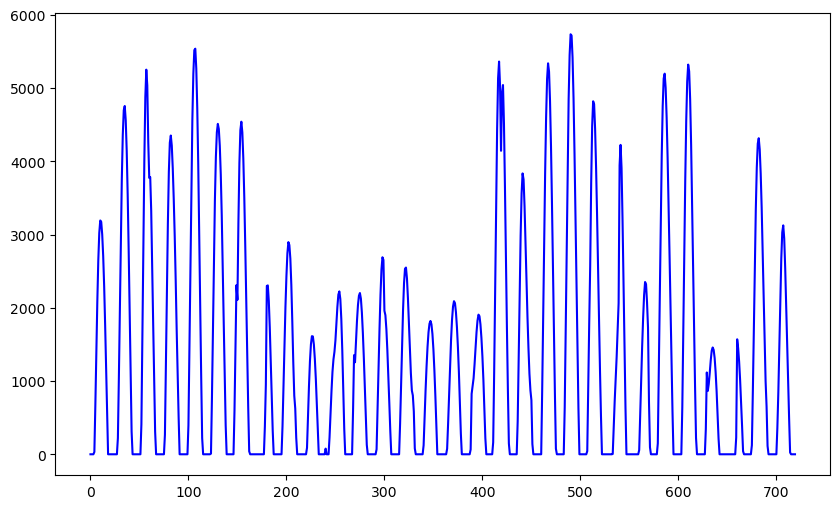

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

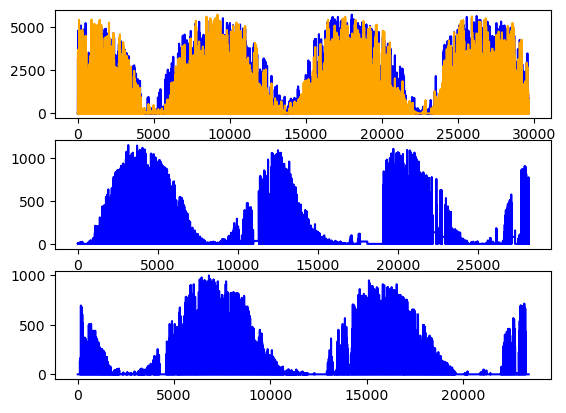

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

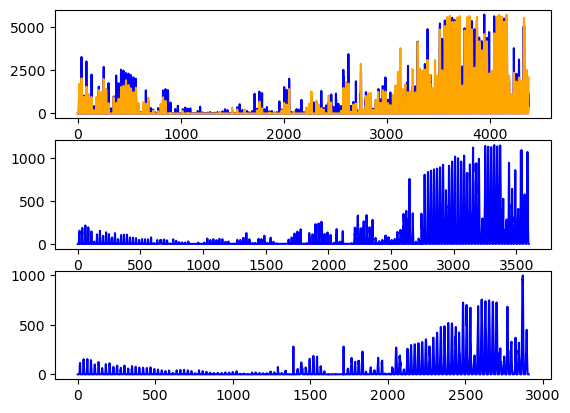

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [199]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [200]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [201]:
submit = np.concatenate((np.concatenate((preds_a, preds_b)),preds_c))

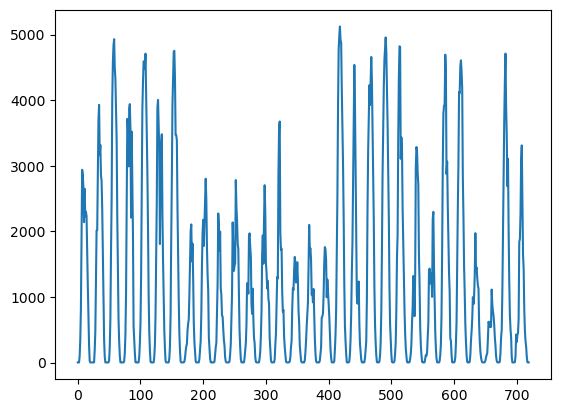

In [203]:
plt.plot(submit[:720])

In [204]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_2.csv", index=False)